In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import datamol as dm
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from rdkit.Chem import RDConfig
from c3pO.icp import ICPClassifier
from c3pO.base import ModelWrapper
from c3pO.nc.classifier import MarginErrFunc, ClassifierNC
from molfeat.trans.fp import FPVecTransformer
from sklearn.pipeline import Pipeline

    

Using backend: pytorch
/Users/manu/.miniconda/envs/expts/lib/python3.7/site-packages/pytorch_lightning/metrics/__init__.py:44: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  "`pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package"


## Loading data

In [49]:

train_path = os.path.join(RDConfig.RDDocsDir, 'Book/data/solubility.train.sdf')
test_path =  os.path.join(RDConfig.RDDocsDir, 'Book/data/solubility.test.sdf')

mol_transformer = FPVecTransformer("desc2D")

train_df = dm.read_sdf(train_path, as_df=True)
test_df = dm.read_sdf(test_path, as_df=True)
train_df = train_df.loc[:,~train_df.columns.duplicated()]
test_df = test_df.loc[:,~test_df.columns.duplicated()]


2021-10-12 19:26:24.622 | WARNING  | datamol.convert:to_df:296 - The SMILES column name provided ('smiles') is already present in the properties of the molecules. THe returned dataframe will two columns with the same name.


In [50]:
label_encoder =  preprocessing.LabelEncoder()
label_encoder.fit(train_df["SOL_classification"])
label_encoder.classes_

array(['(A) low', '(B) medium', '(C) high'], dtype=object)

In [51]:
# random split
train_df["Y"]  = label_encoder.transform(train_df["SOL_classification"])
test_df["Y"]  = label_encoder.transform(test_df["SOL_classification"])
train_df, calib_df = train_test_split(train_df, test_size=0.25, random_state=1234)

In [52]:
clf = RandomForestClassifier()
pipe = Pipeline([('feat', mol_transformer), ('rf', clf)])
pipe.fit(train_df.smiles.values, train_df.Y.values)


Pipeline(steps=[('feat', FPVecTransformer(kind='desc2D')),
                ('rf', RandomForestClassifier())])

In [53]:
from pycm import ConfusionMatrix
import matplotlib.pyplot as plt

<AxesSubplot:title={'center':'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

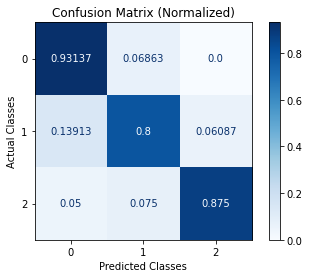

In [54]:
y_pred = pipe.predict(test_df.smiles.values)
y_actu = test_df.Y.values
cm = ConfusionMatrix(actual_vector=y_actu, predict_vector=y_pred) # Create CM From Data
cm.plot(cmap=plt.cm.Blues, normalized=True, number_label=True)

In [69]:
pretrained_model = ModelWrapper(pipe)	# Wrap the model to make it framework agnostic
nc = ClassifierNC(pretrained_model, err_func=MarginErrFunc())	# Create a default nonconformity function
icp = ICPClassifier(nc)	 # Create an inductive conformal classifier
icp.calibrate(calib_df.smiles.values, calib_df.Y.values)


In [68]:
train_data = mol_transformer(train_df.smiles)
test_data = mol_transformer(test_df.smiles)

In [126]:
from c3pO.utils import coverage

icp_predict = icp.predict(test_df.smiles, significance=0.05)
icp_predict_conf = icp.predict_conf(test_df.smiles)

In [137]:
coverage(icp_predict, test_df.Y.values)

0.9299610894941635

In [122]:
from sklearn.metrics import accuracy_score

accuracy_score(pipe.predict(test_df.smiles.values), test_df.Y.values)

0.8638132295719845

In [98]:
import scipy.spatial as ss
dist_mat = ss.distance.cdist(test_data, train_data, metric="correlation")

In [100]:
import pandas as pd
df = pd.DataFrame(icp_predict, columns=["label", "confidence", "credibility"])

In [109]:
df["dist"] = dist_mat.mean(axis=1)
dist_mat

array([[0.23454436, 0.04506749, 0.71149861, ..., 0.11303177, 0.85732589,
        0.31654112],
       [0.21135318, 0.04179225, 0.72244625, ..., 0.09949844, 0.87592094,
        0.29465988],
       [0.17664227, 0.04399721, 0.72954985, ..., 0.06670615, 0.89111331,
        0.28246719],
       ...,
       [0.80730091, 0.9377494 , 0.03447844, ..., 0.95635822, 0.00128056,
        0.54495169],
       [0.80723633, 0.937704  , 0.03446095, ..., 0.95630563, 0.00127718,
        0.54489112],
       [0.80720756, 0.93767523, 0.03445323, ..., 0.95627784, 0.00127559,
        0.54486462]])

In [110]:
df

,label,confidence,credibility,dist
0,0.0,0.987109,0.600541,0.473977
1,0.0,0.977588,0.480742,0.475166
2,1.0,0.981851,0.570454,0.477022
3,1.0,0.943282,0.346029,0.395919
4,1.0,0.985121,0.581271,0.475222
...,...,...,...,...
252,0.0,0.998148,0.972259,0.381444
253,0.0,0.986972,0.598650,0.383341
254,0.0,0.911512,0.246396,0.383441
255,0.0,0.969282,0.431030,0.383408


<AxesSubplot:xlabel='dist', ylabel='confidence'>

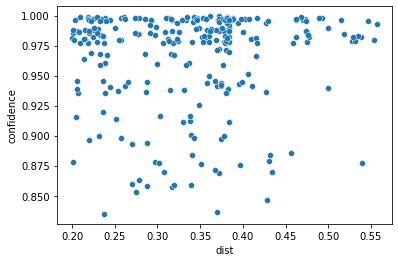

In [111]:
import seaborn as sns

sns.scatterplot(x="dist", y="confidence", data=df)

<AxesSubplot:xlabel='dist', ylabel='credibility'>

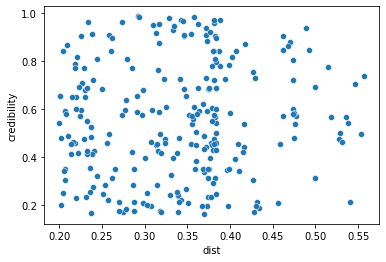

In [112]:
import seaborn as sns

sns.scatterplot(x="dist", y="credibility", data=df)